In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

%load_ext autoreload
%autoreload 2
# %matplotlib notebook

In [4]:
from ndgsp.graph.graphs import Graph, ProductGraph

2023-02-09 11:30:58.830322: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Using Jax backend with device TFRT_CPU_0


In [3]:
from numpy import eye as I
J = lambda N: np.ones((N, N))

In [4]:
np.random.seed(0)

In [5]:
def check_rule(A_A: np.ndarray, 
               A_B: np.ndarray, 
               a: int, 
               b: int, 
               a_: int, 
               b_: int, 
               rule: int):
    """
    For a given product graph rule, check whether two nodes (a, b) and (a_, b_)
    are connected in the product of graphs with adjacency matrices A_A and A_B
    """
    
    if rule == 1:
        return A_A[a, a_] and b == b_
    
    if rule == 2:
        return not A_A[a, a_] and b == b_
    
    if rule == 3:
        return A_A[a, a_] and A_B[b, b_]
    
    if rule == 4:
        return not A_A[a, a_] and A_B[b, b_]
    
    if rule == 5:
        return A_A[a, a_] and not A_B[b, b_]
    
    if rule == 6:
        return not A_A[a, a_] and not A_B[b, b_]
    
    if rule == 7:
        return a == a_ and A_B[b, b_]
    
    if rule == 8:
        return a == a_ and not A_B[b, b_]

    raise ValueError('rule should be an int from 1-8')


def get_A_from_rules(A_A: np.ndarray, 
                     A_B: np.ndarray, 
                     rules: list[int]):
    """
    Create a product graph adjacency matrix using the factor 
    adjacency matrices and a set of rules
    """
    
    A = len(A_A)
    B = len(A_B)
    
    out = np.zeros((A * B, A * B))

    nodes = np.argwhere(np.ones((A, B)))
    
    for i, (a, b) in enumerate(nodes): 
        
        for j, (a_, b_) in enumerate(nodes):
            
            out[i, j] = out[j, i] = any(check_rule(A_A, A_B, a, b, a_, b_, rule) for rule in rules)
            
    return out


def get_A_from_adjacency(A_A: np.ndarray,
                         A_B: np.ndarray,
                         product: str):
    """
    Create a product graph adjacency matrix for a given product
    using the factor adjacency matrices
    """

        
    NA = len(A_A)
    NB = len(A_B)
    
    if product == 'Cartesian':
        
        return np.kron(A_A, I(NB)) + np.kron(I(NA), A_B)
    
    if product == 'direct':
        
        return np.kron(A_A, A_B)
    
    if product == 'strong':
        
        return np.kron(A_A, I(NB)) + np.kron(I(NA), A_B) + np.kron(A_A, A_B)
    
    if product == 'lexicographic':
        
        return np.kron(A_A, J(NB)) + np.kron(I(NA), A_B)


def check_A_consistent():
    """
    Check that constructing the product graph adjacency from the rules 
    and from the adjacency matrix products result in the same graph
    """

    GA = Graph.random_connected(8)
    GB = Graph.random_connected(10)

    for product, rules in [('Cartesian', [1, 7]), 
                        ('direct', [3]), 
                        ('strong', [1, 3, 7]), 
                        ('lexicographic', [1, 3, 5, 7])]:

        A1 = get_A_from_rules(GA.A, GB.A, rules)
        A2 = get_A_from_adjacency(GA.A, GB.A, product)

        assert(np.allclose(A1, A2))

    return True




In [6]:
check_A_consistent()

True

In [7]:
    
def get_L(A_A: np.ndarray, 
          A_B: np.ndarray, 
          L_A: np.ndarray, 
          L_B: np.ndarray, 
          product: str):
    """
    Get the product graph Laplacian matrix
    """

    NA = len(A_A)
    NB = len(A_B)
    
    D_A = np.diag(A_A.sum(0))
    D_B = np.diag(A_B.sum(0))
           
    if product == 'Cartesian':
        
        return np.kron(L_A, I(NB)) + np.kron(I(NA), L_B)
    
    if product == 'direct':
        
        return np.kron(D_A, L_B) + np.kron(L_A, D_B) - np.kron(L_A, L_B)
    
    if product == 'strong':
        
        return np.kron(L_A, I(NB)) + np.kron(I(NA), L_B) + np.kron(D_A, L_B) + np.kron(L_A, D_B) - np.kron(L_A, L_B)
    
    if product == 'lexicographic':
        
        return np.kron(I(NA), L_B) + np.kron(L_A, J(NB)) + np.kron(D_A, NB * I(NB) - J(NB))  
    

def check_L_consistent():
    """
    Check that the kronecker construction methods for the product graph 
    Laplacian are consistent
    """

    GA = Graph.random_connected(8)
    GB = Graph.random_connected(10)

    for product in ['Cartesian', 'direct', 'strong', 'lexicographic']:

        L1 = get_L(GA.A, GB.A, GA.L, GB.L, product)
        
        A2 = get_A_from_adjacency(GA.A, GB.A, product)
        L2 = np.diag(A2.sum(0)) - A2

        assert(np.allclose(L1, L2))

    return True


In [8]:
check_L_consistent()

True

In [9]:
def get_product_eigs(L_A: np.ndarray, L_B: np.ndarray, product: str):
    """
    Given the factor Laplacians, return the eigenvalues and eigenvectors of 
    the product Laplacian for a given product type. 

    Note that the direct and strong solutions only work for regular factor graphs
    """

    lamA, UA = np.linalg.eigh(L_A)
    lamB, UB = np.linalg.eigh(L_B)

    if product == 'Cartesian':

        lam = np.kron(lamA, np.ones_like(lamB)) + np.kron(np.ones_like(lamA), lamB)
        U = np.kron(UA, UB)

    if product == 'direct':

        rA = -L_A[0, 1:].sum()
        rB = -L_B[0, 1:].sum()
        lam = rB * np.kron(lamA, np.ones_like(lamB)) + rA * np.kron(np.ones_like(lamA), lamB) - np.kron(lamA, lamB)
        U = np.kron(UA, UB)

    if product == 'strong':
        
        rA = -L_A[0, 1:].sum()
        rB = -L_B[0, 1:].sum()
        lam = (1 + rB) * np.kron(lamA, np.ones_like(lamB)) + (1 + rA) * np.kron(np.ones_like(lamA), lamB) - np.kron(lamA, lamB)
        U = np.kron(UA, UB)

    if product == 'lexicographic':

        dA = -np.tril(L_A, -1).sum(0) - np.triu(L_A, 1).sum(0)
        lam1 = len(L_B) * np.kron(dA, np.ones_like(lamB[1:])) + np.kron(np.ones_like(lamA), lamB[1:])
        U1 = np.kron(I(len(L_A)), UB[:, 1:])

        lam2 = lamA * len(L_B)
        U2 = np.array([np.kron(UA[:, i], np.ones(len(L_B))) for i in range(len(lamA))]).T
        U2 /= np.linalg.norm(U2, axis=0)

        lam = np.concatenate([lam1, lam2])
        U = np.concatenate([U1, U2], axis=1)

    return lam, U


In [10]:
def check_eigs_consistent(): 

    for product in ['Cartesian', 'direct', 'strong', 'lexicographic']:

        if product in ['strong', 'direct']:

            GA = Graph.random_regular(6, 3)
            GB = Graph.random_regular(8, 3)

        else:
            GA = Graph.random_connected(6)
            GB = Graph.random_connected(8)


        lam, U = get_product_eigs(GA.L, GB.L, product)
        L = get_L(GA.A, GB.A, GA.L, GB.L, product)

        assert np.allclose(U @ np.diag(lam) @ U.T, L)

    return True


check_eigs_consistent()


True

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `filter_types_butterfly.pdf'.


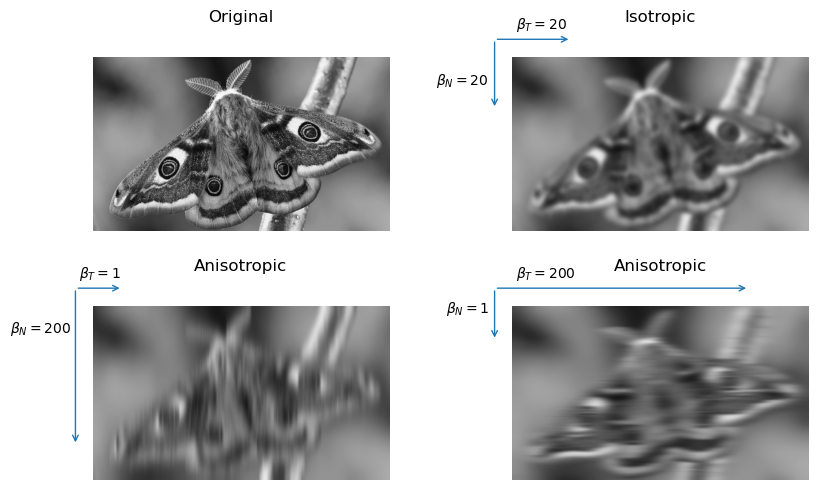

In [5]:

import subprocess
from PIL import Image
from ndgsp.graph.filters import MultivariateFilterFunction
import matplotlib.patches as mpatches


def generate_butterflies_image():

    im = Image.open('data/butterflies_raw.jpg')
    im.thumbnail((856, 856))

    Y_true = np.array(im).mean(-1)
    Y_true = (Y_true - Y_true.mean()) / Y_true.std()
    N, T = Y_true.shape

    G = ProductGraph.lattice(N, T)

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

    axes[0, 0].imshow(Y_true, vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')

    H = MultivariateFilterFunction.diffusion(beta=[20, 20])
    axes[0, 1].imshow(G.filter(Y_true, H), vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')

    H = MultivariateFilterFunction.diffusion(beta=[200, 1])
    axes[1, 0].imshow(G.filter(Y_true, H), vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')

    H = MultivariateFilterFunction.diffusion(beta=[1, 200])
    axes[1, 1].imshow(G.filter(Y_true, H), vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')


    for ax in axes.flatten():
        ax.axis('off')

    axes[0, 0].set_title('Original', pad=25)
    axes[0, 1].set_title('Isotropic', pad=25)
    axes[1, 0].set_title('Anisotropic', pad=25)
    axes[1, 1].set_title('Anisotropic', pad=25)

    r = N / T

    arrow_style = dict(arrowstyle="<-", color='tab:blue')

    axes[0, 1].annotate('', xy=(-0.1 * r, 1.1),  xytext=(0.2, 1.1),  xycoords='axes fraction', arrowprops=arrow_style)
    axes[0, 1].annotate('', xy=(-0.1 * r, 1.1),  xytext=(-0.1 * r, 0.7),  xycoords='axes fraction', arrowprops=arrow_style)
    axes[0, 1].text(-220, 80, r'$\beta_N = 20$')
    axes[0, 1].text(10, -80, r'$\beta_T= 20$')

    axes[1, 1].annotate('', xy=(-0.1 * r, 1.1),  xytext=(0.8, 1.1),  xycoords='axes fraction', arrowprops=arrow_style)
    axes[1, 1].annotate('', xy=(-0.1 * r, 1.1),  xytext=(-0.1 * r, 0.8),  xycoords='axes fraction', arrowprops=arrow_style)
    axes[1, 1].text(-190, 20, r'$\beta_N = 1$')
    axes[1, 1].text(10, -80, r'$\beta_T= 200$')

    axes[1, 0].annotate('', xy=(-0.1 * r, 1.1),  xytext=(0.1, 1.1),  xycoords='axes fraction', arrowprops=arrow_style)
    axes[1, 0].annotate('', xy=(-0.1 * r, 1.1),  xytext=(-0.1 * r, 0.2),  xycoords='axes fraction', arrowprops=arrow_style)
    axes[1, 0].text(-240, 80, r'$\beta_N = 200$')
    axes[1, 0].text(-40, -80, r'$\beta_T= 1$')

    fig.tight_layout(h_pad=2.0, w_pad=-7.0)

    plt.savefig('filter_types_butterfly.pdf')
    
    subprocess.run(['pdfcrop', 'filter_types_butterfly.pdf', 'filter_types_butterfly.pdf'])


generate_butterflies_image()